In [1]:
import pylab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
flow = pd.read_csv("flow.tsv", na_values=['-'], delimiter="\t", error_bad_lines=False)
occupancy = pd.read_csv("occupancy.tsv", na_values=['-'], delimiter="\t", error_bad_lines=False)
speed = pd.read_csv("speed.tsv", na_values=['-'], delimiter="\t", error_bad_lines=False)
timestamp = pd.read_csv("timestamp.tsv", na_values=['-'], delimiter="\t", error_bad_lines=False)

In [3]:
flow.head()

,14,13
0,21.0,20.0
1,7.0,6.0
2,26.0,23.0
3,9.0,12.0
4,16.0,16.0


In [4]:
df = pd.concat([flow,occupancy,speed,timestamp], axis=1)

In [6]:
df.columns = ['flow1','flow2','occupancy1','occupancy2','speed1','speed2','timestamp']
df.head()

,flow1,flow2,occupancy1,occupancy2,speed1,speed2,timestamp
0,21.0,20.0,9.0,11.0,58.2,63.0,2009-08-19T15:05:52
1,7.0,6.0,2.0,2.0,60.0,63.0,2009-08-19T15:06:52
2,26.0,23.0,10.0,10.0,58.8,61.8,2009-08-19T15:07:53
3,9.0,12.0,3.0,6.0,61.8,61.8,2009-08-19T15:08:53
4,16.0,16.0,6.0,7.0,64.8,63.6,2009-08-19T15:09:53


In [7]:
df1 =  pd.DataFrame({"flow" : df.flow1, "occupancy" : df.occupancy1,"speed" : df.speed1,"timestamp" : df.timestamp,"detector" : "x"})
df2 = pd.DataFrame({"flow" : df.flow2, "occupancy" : df.occupancy2,"speed" : df.speed2,"timestamp" : df.timestamp,"detector" : "y"})

In [8]:
frames = [df1, df2]
result = pd.concat(frames)

In [9]:
result = result.sort_values("timestamp")

In [10]:
result.head()

,detector,flow,occupancy,speed,timestamp
0,x,21.0,9.0,58.2,2009-08-19T15:05:52
0,y,20.0,11.0,63.0,2009-08-19T15:05:52
1,y,6.0,2.0,63.0,2009-08-19T15:06:52
1,x,7.0,2.0,60.0,2009-08-19T15:06:52
2,x,26.0,10.0,58.8,2009-08-19T15:07:53


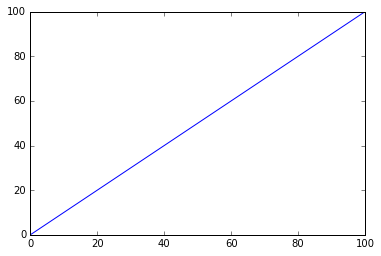

In [11]:
# Finding outlier values for Occoupancy
val = np.sort(result["occupancy"].unique())
plt.plot(val)

In [13]:
print (np.sort(result["flow"].unique()))

[-51. -49. -47. -46. -45. -44. -43. -41. -40. -39. -38. -37. -36. -35. -34.
 -33. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23. -22. -21. -20. -19.
 -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.
  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.
  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  76.  nan]


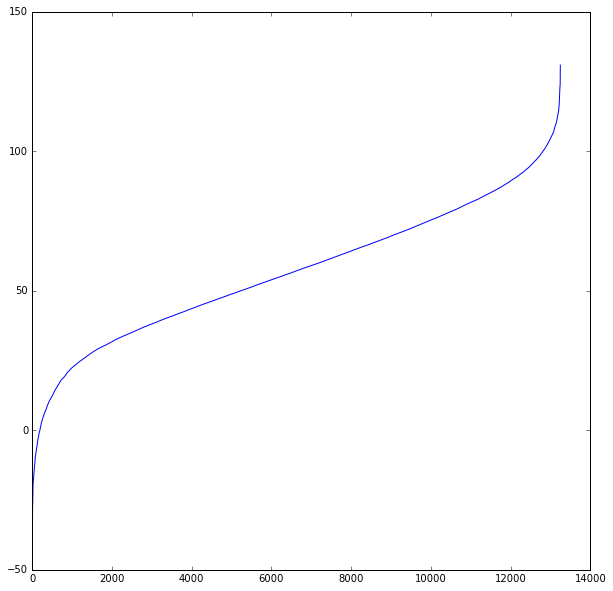

In [14]:
# Outlier speed visualization
plt.figure(figsize=(10,10))
plt.plot(np.sort(result["speed"].unique()))

In [16]:
removeResult1 = result[(result['speed'] < 0) | (result['flow'] < 0)]
removeResult2 = result[(result['flow'] == 0) & (result['speed'] > 0)]
jam_occupancy_threshold = 100
removeResult3 = result[((result['speed'] == 0) & 
                            (result['flow'] == 0) & 
                            (result['occupancy'] != 0) & 
                            (result['occupancy'] < jam_occupancy_threshold))]
#removeResult4 = result[(result['speed'] == 0) & (result['flow'] == 0) & (result["occupancy"] == 0)]
removeResult5 = result[(result['speed'] == 0) & (result['flow'] != 0) & (result["occupancy"] == 0)]
removeResult6 = result[(pd.isnull(result['speed'])) | (pd.isnull(result['occupancy'])) | (pd.isnull(result['flow']))]

In [17]:
result.head()

,detector,flow,occupancy,speed,timestamp
0,x,21.0,9.0,58.2,2009-08-19T15:05:52
0,y,20.0,11.0,63.0,2009-08-19T15:05:52
1,y,6.0,2.0,63.0,2009-08-19T15:06:52
1,x,7.0,2.0,60.0,2009-08-19T15:06:52
2,x,26.0,10.0,58.8,2009-08-19T15:07:53


In [18]:
res = result.set_index(["timestamp","detector"]).sort_index()

In [19]:
result = pd.concat([result,removeResult1,removeResult1]).drop_duplicates(keep=False)
result = pd.concat([result,removeResult2,removeResult2]).drop_duplicates(keep=False)
result = pd.concat([result,removeResult3,removeResult3]).drop_duplicates(keep=False)
#result = pd.concat([result,removeResult4,removeResult4]).drop_duplicates(keep=False)
result = pd.concat([result,removeResult5,removeResult5]).drop_duplicates(keep=False)
result = pd.concat([result,removeResult6,removeResult6]).drop_duplicates(keep=False)

In [20]:
result = result.sort_values(["flow"])

In [21]:
def sampleData(data, threshold, columnName):
    flowBins = np.zeros(shape=(20,), dtype = object)
    data = data.sort_values(columnName)
    difference = threshold
    high  = difference
    low = 0;
    for i in range(0, 20, 1):
        b = data[data[columnName] < high]
        b = b[b[columnName] >= low]
        flowBins[i] = b
        low = high
        high = high + difference
    return flowBins

In [22]:
flowBins = np.zeros(shape=(20,), dtype = object)
flowBins = sampleData(result, 4 ,"flow")    

In [23]:

flow_occupancy_bin = np.ndarray(shape=(20,20), dtype = object)
for i in range(0,20,1):
    data = pd.DataFrame(flowBins[i])
    flow_occupancy_bin[i] = sampleData(data, 6 ,"occupancy") 

In [24]:
flow_occupancy_speed_bin = np.ndarray(shape=(20,20,20), dtype = object)
for i in range(0,20,1):
    for j in range(0,20,1):
        data = flow_occupancy_bin[i][j];
        flow_occupancy_speed_bin[i][j] = sampleData(data, 7 ,"speed") 

In [25]:
!mkdir output

In [26]:
final_result = pd.DataFrame(columns = ["detector","flow","occupancy","speed","timestamp", "probability"])
total_points = len(result)
for i in range(0,20,1):
    for j in range(0,20,1):
        for k in range(0,20,1):
            prob_data = flow_occupancy_speed_bin[i][j][k]
            points_inside_box = prob_data.shape[0]
            f = prob_data.flow.max() - prob_data.flow.min()
            o = prob_data.occupancy.max() - prob_data.occupancy.min()
            s = prob_data.speed.max() - prob_data.speed.min()
            volume = 1170
            if(volume == 0): volume =1
            probability = points_inside_box/float(total_points * volume)
            prob_data["probability"] = probability
            prob_data.to_csv("output/out" + str(i) + '-' + str(j) + '-' + str(k) + ".csv",sep="\t")

In [27]:
! cat output/*.csv > merged.csv

In [28]:
!rm -rf output/

In [29]:
merged = pd.read_csv("merged.csv", na_values=['-'], delimiter="\t", error_bad_lines=False)

/Users/abhisheknigam/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (2,3,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
removeHeader = merged[merged["probability"] == "probability"]

In [31]:
merged = pd.concat([merged,removeHeader,removeHeader]).drop_duplicates(keep=False)

In [32]:
merged.tail()

,Unnamed: 0,detector,flow,occupancy,speed,timestamp,probability
5757620,1679116.0,x,36.0,58.0,39.6,2013-01-25T16:16:43,1.7838383089712305e-09
5757622,1393050.0,y,37.0,55.0,42.6,2012-06-23T09:15:49,5.946127696570769e-10
5757623,1233438.0,x,37.0,54.0,43.2,2012-03-02T17:43:13,5.946127696570769e-10
5757624,2023906.0,y,38.0,59.0,45.6,2013-09-27T21:47:40,5.946127696570769e-10
5757625,1498179.0,x,36.0,54.0,46.2,2012-09-06T09:34:11,5.946127696570769e-10


In [33]:
removeResult1["probability"] = 0
removeResult2["probability"] = 0
removeResult3["probability"] = 0
#removeResult4["probability"] = 0
removeResult5["probability"] = 0
removeResult6["probability"] = 0

In [34]:
merged = merged.append(removeResult1);
merged = merged.append(removeResult2);
merged = merged.append(removeResult3);
#merged = merged.append(removeResult4);
merged = merged.append(removeResult5);
merged = merged.append(removeResult6);

In [35]:
# merged = merged.reset_index(drop=True)
merged["probability"] = merged["probability"].apply(pd.to_numeric)
merged = merged.sort_values(["probability"])
final_columns = ['flow', 'speed', 'occupancy', 'probability']
merged = merged[final_columns]

In [36]:
merged.tail()

,flow,speed,occupancy,probability
4120208,16,58.8,11,0.000072
4120207,19,58.8,8,0.000072
4120206,18,58.8,8,0.000072
4120218,18,58.8,9,0.000072
4075295,17,58.2,7,0.000072


In [37]:
final_result = pd.DataFrame(columns = ["flow","speed","occupancy", "probability"])
for i in range(0,len(merged),100):
    final_result = final_result.append(merged.iloc[[i]])

In [38]:
final_result.to_csv("3232_2.txt",sep="\t", index=False)

In [39]:
final_result.head()

,flow,speed,occupancy,probability
2799101,NaN,NaN,NaN,0.0
970178,0,53.4,0,0.0
970329,0,53.4,0,0.0
970283,0,53.4,0,0.0
970027,0,45.6,0,0.0


In [41]:
low = 0;
high1 = int(len(result)/20)
BinNum = 20;
length = high1 - low
flowBins = np.zeros(shape=(20,high1), dtype = object)
for i in range(0, 20, 1):
    high = low + high1
    flowBins[i] = [result[low : high]]
    low = high

In [42]:
import numpy as np
flow_occupancy_bin = np.ndarray(shape=(20,20), dtype = object)
y = 1;
low = 0;
for i in range(0,20,1):
    data = pd.DataFrame(flowBins[i].reshape((-1,length))[0][0]);
    data = data.sort_values(["occupancy"])
    high1 = int(len(flowBins[1])/20)
    low = 0
    for j in range(0, 20, 1):
        high = low + high1
        flow_occupancy_bin[i][j] = [data[low : high]]
        low = high

In [43]:
import numpy as np
flow_occupancy_speed_bin = np.ndarray(shape=(20,20,20), dtype = object)
for i in range(0,20,1):
    for k in range(0,20,1):
        data = flow_occupancy_bin[i][k][0];
        data = data.sort_values(["speed"])
        low = 0;
        high1 = int(len(flow_occupancy_bin[0][0][0])/20)
        for j in range(0, 20, 1):
            high = low + high1
            flow_occupancy_speed_bin[i][k][j] = [data[low : high]]
            low = high

In [44]:
!mkdir output

In [45]:
vectors = len(result)
for i in range(1,20,1):
    for j in range(1,20,1):
        for k in range(1,20,1):
            prob_data = flow_occupancy_speed_bin[i][j][k][0]
            currVectors = flow_occupancy_speed_bin[i][j][k][0].shape[0]
            flow_difference = prob_data.flow.max() - prob_data.flow.min()
            occupancy_difference = prob_data.occupancy.max() - prob_data.occupancy.min()
            speed_difference = prob_data.speed.max() - prob_data.speed.min()
            volume = flow_difference * occupancy_difference * speed_difference
            if(volume == 0): volume =1
            probability = currVectors/float(vectors * volume)
            prob_data["probability"] = probability
            prob_data.to_csv("output/out" + str(i) + '-' + str(j) + '-' + str(k) + ".csv",sep="\t")  

/Users/abhisheknigam/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
! cat output/*.csv > merged-1.csv

In [47]:
!rm -rf output/

In [48]:
merged = pd.read_csv("merged-1.csv", na_values=['-'], delimiter="\t", error_bad_lines=False)

In [49]:
removeHeader = merged[merged["probability"] == "probability"]
merged = pd.concat([merged,removeHeader,removeHeader]).drop_duplicates(keep=False)

In [50]:
removeResult1["probability"] = 0
removeResult2["probability"] = 0
removeResult3["probability"] = 0
#removeResult4["probability"] = 0
removeResult5["probability"] = 0
removeResult6["probability"] = 0

In [51]:
merged = merged.append(removeResult1);
merged = merged.append(removeResult2);
merged = merged.append(removeResult3);
#merged = merged.append(removeResult4);
merged = merged.append(removeResult5);
merged = merged.append(removeResult6);

In [52]:
merged["probability"] = merged["probability"].apply(pd.to_numeric)
merged = merged.sort_values(["probability"])
final_columns = ['flow', 'speed', 'occupancy', 'probability']
merged = merged[final_columns]

In [53]:
merged.tail()

,flow,speed,occupancy,probability
1165741,16.0,60.0,8.0,0.001249
1165742,16.0,60.0,8.0,0.001249
1165743,16.0,60.0,9.0,0.001249
1165723,16.0,60.0,8.0,0.001249
1165679,16.0,60.0,8.0,0.001249


In [54]:
final_result = pd.DataFrame(columns = ["flow","speed","occupancy", "probability"])
for i in range(0,len(merged),100):
    final_result = final_result.append(merged.iloc[[i]])

In [55]:
final_result.to_csv("3232_2.txt",sep="\t", index=False)